Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [2]:

data_set = input_data.read_data_sets('', False)
training_data=data_set.train
testing_data=data_set.test

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


In [3]:

images_feed, labels_feed = training_data.next_batch(10000,False)
image_size = 28
num_labels = 10
np.min(images_feed)

0.0

In [34]:
tf.nn.dropout?

In [4]:
training_data.next_batch(10)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([5, 1, 1, 3, 6, 2, 6, 3, 3, 1], dtype=uint8))

(784, 196)
(196, 784)


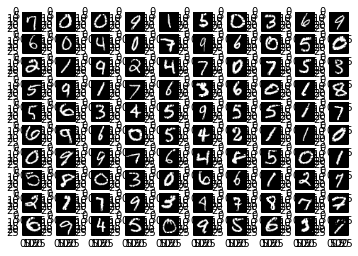

In [146]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)
fig = plt.figure()
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(batch_data[i].reshape(image_size,image_size), cmap=cm.gray)

Do validation testing:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [8]:
validation_data=data_set.validation
valid_batch,_=validation_data.next_batch(validation_data.num_examples)

5000

In [21]:
batch_size = 128
nHidden=196
beta=3
rho=.1

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_valid_dataset = tf.constant(valid_batch)
  #tf_test_dataset = tf.constant(test_dataset)
   
  # Variables.
  weights_hidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, nHidden],stddev=0.01))
  weights = tf.Variable(tf.truncated_normal([nHidden, image_size*image_size],stddev=0.01))
  biases_hidden1 = tf.Variable(tf.zeros([nHidden]))
  biases = tf.Variable(tf.zeros([image_size*image_size]))
  
  # Training computation.
  hidden_comp=tf.matmul(tf_train_dataset, weights_hidden1)
  hidden1 = tf.nn.sigmoid(tf.mul(hidden_comp  + biases_hidden1,8))
  output_units = tf.nn.sigmoid(tf.matmul(hidden1, weights) + biases)
  int_rho=tf.reduce_sum(hidden1,0)
  rho_hat=tf.div(int_rho,batch_size)
  rho_hat_mean=tf.reduce_mean(rho_hat)
  rho_in=tf.sub(tf.constant(1.),rho)
  rho_hat_in=tf.sub(tf.constant(1.),rho_hat)
  klterm=tf.add(tf.mul(rho,tf.log(tf.div(rho,rho_hat))),tf.mul(rho_in,tf.log(tf.div(rho_in,rho_hat_in))))
  kl_div=tf.reduce_sum(klterm)
  loss = tf.div(tf.nn.l2_loss(tf.sub(output_units, tf_train_dataset)),tf.constant(float(batch_size)))+ beta*kl_div
            
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.0075).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  valid_output_units=tf.nn.sigmoid(tf.matmul(tf.nn.sigmoid(tf.mul(tf.matmul(tf_valid_dataset, weights_hidden1)  + biases_hidden1,8)),weights)+biases)
  valid_loss= tf.div(tf.nn.l2_loss(tf.sub(valid_output_units, tf_valid_dataset)),tf.constant(float(batch_size)))
    #l2_loss variation check
    #adaptive beta
    #sigmoid output

In [22]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Generate a minibatch.
    batch_data,_ = training_data.next_batch(batch_size)
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data}
    _, l, feature_weights, rhohat= session.run(
      [optimizer, loss, weights_hidden1,rho_hat_mean], feed_dict=feed_dict)
    if step%500==0:
        _, v_l, valid_out_data = session.run([optimizer, valid_loss,valid_output_units], feed_dict=feed_dict)
        print("step", step," \tTrain loss ",l, "\tValid loss",v_l, "\t Mean Rho-hat",rhohat)
        
# for i in xrange(batch_size):
    #        plt.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

Initialized
step 0  	Train loss  312.119 	Valid loss 90.5915 	 Mean Rho-hat 0.492639
step 500  	Train loss  48.6604 	Valid loss 43.1986 	 Mean Rho-hat 0.123862
step 1000  	Train loss  34.3729 	Valid loss 28.9394 	 Mean Rho-hat 0.126303
step 1500  	Train loss  30.2333 	Valid loss 24.3925 	 Mean Rho-hat 0.116539
step 2000  	Train loss  25.2293 	Valid loss 21.6704 	 Mean Rho-hat 0.116089
step 2500  	Train loss  23.727 	Valid loss 19.8153 	 Mean Rho-hat 0.120912
step 3000  	Train loss  21.8883 	Valid loss 18.5545 	 Mean Rho-hat 0.115843
step 3500  	Train loss  21.0137 	Valid loss 17.7788 	 Mean Rho-hat 0.123644
step 4000  	Train loss  19.5678 	Valid loss 16.8714 	 Mean Rho-hat 0.117708
step 4500  	Train loss  18.6692 	Valid loss 16.2133 	 Mean Rho-hat 0.11798
step 5000  	Train loss  17.258 	Valid loss 15.7456 	 Mean Rho-hat 0.115217
step 5500  	Train loss  17.3509 	Valid loss 15.1004 	 Mean Rho-hat 0.116228
step 6000  	Train loss  18.4159 	Valid loss 14.6054 	 Mean Rho-hat 0.109012
step 65

(784, 196)
(196, 784)


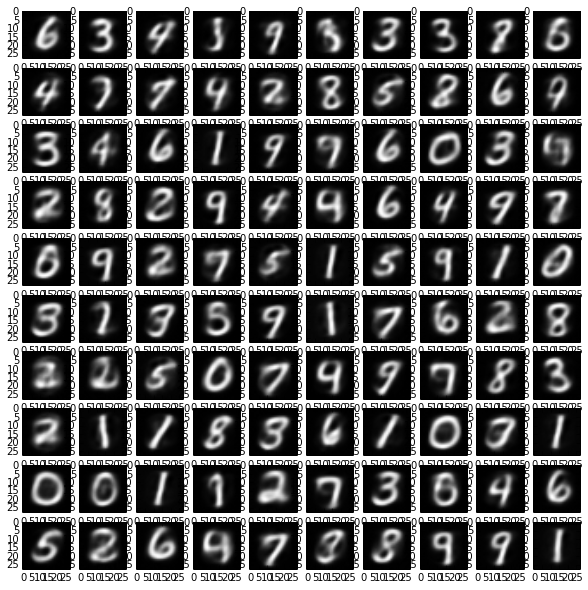

In [23]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(valid_out_data[i].reshape(image_size,image_size), cmap=cm.gray)

(784, 196)
(196, 784)


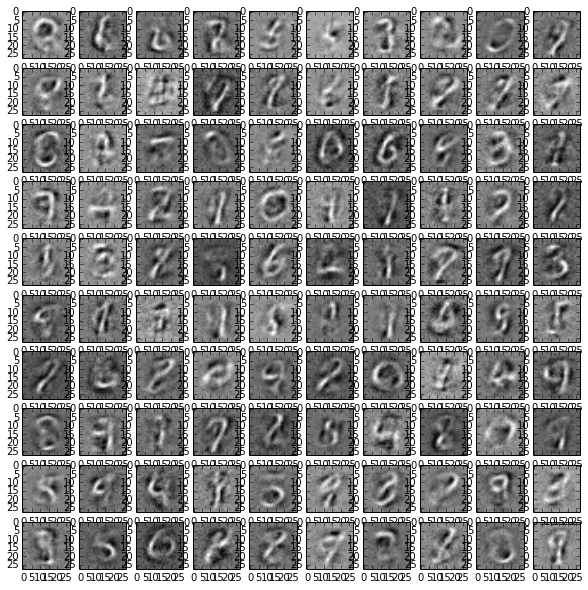

In [24]:
print(feature_weights.shape)
features=feature_weights.transpose()  
print(features.shape)

fig = plt.figure(figsize = (10,10))
for i in range(100):
   ax = fig.add_subplot(10,10,i)
   ax.imshow(features[i].reshape(image_size,image_size), cmap=cm.gray)

In [29]:
fig = plt.figure()
fig.add_subplot(1,)